<a href="https://colab.research.google.com/github/AryanGupta0419/PytorchTutorial/blob/main/DL_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Visualization and ANN on MNIST

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torch
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#MNIST (60000 x 1 x 28 x 28)


In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.85MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_data = next(iter(train_loader))
images, labels = train_data
print(images.shape)

torch.Size([64, 1, 28, 28])


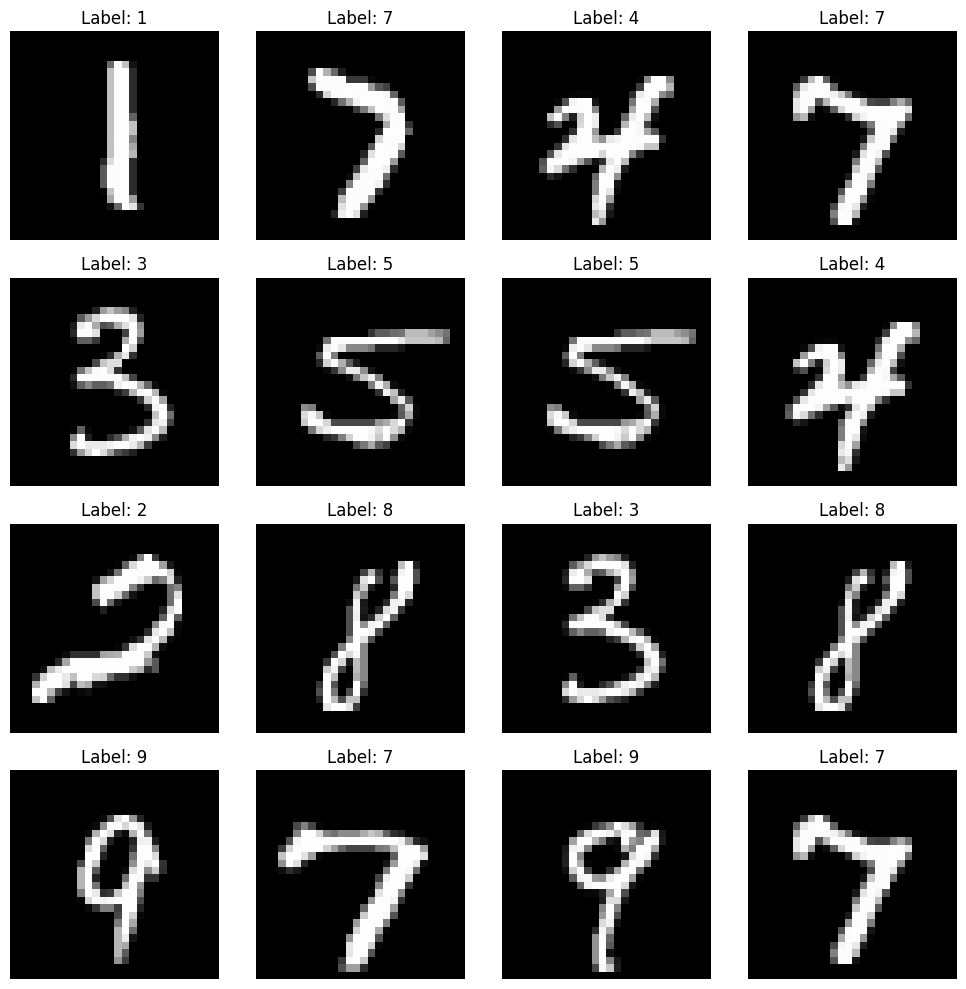

In [ ]:
plt.figure(figsize=(10, 10))
indices = torch.randint(0, 16, (16,))
for i, idx in enumerate(indices):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[idx][0], cmap='gray')
    plt.title(f"Label: {labels[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<ipython-input-10-1660278b3b6a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_cpu, palette='viridis')


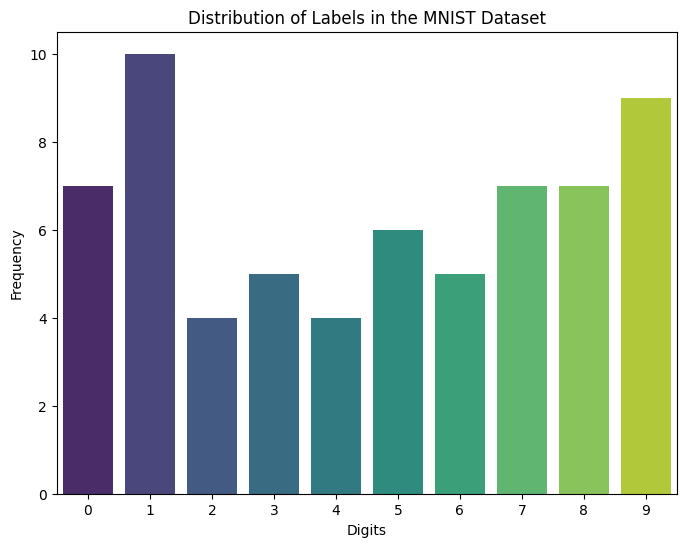

In [ ]:
labels_cpu = labels.cpu().numpy()
plt.figure(figsize=(8, 6))
sns.countplot(x=labels_cpu, palette='viridis')
plt.title("Distribution of Labels in the MNIST Dataset")
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.show()

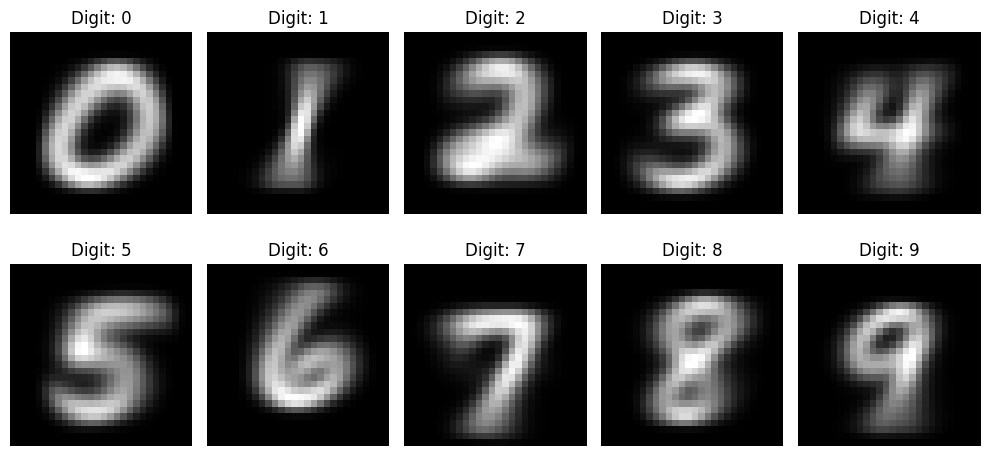

In [ ]:
all_images = []
all_labels = []

for data in train_loader:
    images, labels = data
    all_images.append(images)
    all_labels.append(labels)

# Concatenate the batches to form the full dataset
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)


averages = []
for digit in range(10):
    digit_images = all_images[all_labels == digit]

    digit_mean = digit_images.mean(dim=0)
    averages.append(digit_mean.numpy())

plt.figure(figsize=(10, 5))
for i, avg in enumerate(averages):
    plt.subplot(2, 5, i + 1)
    plt.imshow(avg[0], cmap='gray')
    plt.title(f"Digit: {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#Model Definition

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)


#Training

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criteria(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 300 == 299:    # Print every 300 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 300:.3f}')
            running_loss = 0.0


[1,   300] loss: 0.455
[1,   600] loss: 0.241
[1,   900] loss: 0.176
[2,   300] loss: 0.140
[2,   600] loss: 0.139
[2,   900] loss: 0.125
[3,   300] loss: 0.107
[3,   600] loss: 0.095
[3,   900] loss: 0.098
[4,   300] loss: 0.080
[4,   600] loss: 0.088
[4,   900] loss: 0.083
[5,   300] loss: 0.073
[5,   600] loss: 0.066
[5,   900] loss: 0.068


#Evaluation

In [ ]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 97.40%
